# Домашее задание №5

В файле bank-additional-full.csv содержаться данные о маркетинговой кампании банка.

Описание переменных

Bank client data:

    •	age (numeric)
    •	job : type of job (categorical)
    •	marital : marital status (categorical)
    •	education (categorical)
    •	default: has credit in default? (categorical)
    •	housing: has housing loan? (categorical)
    •	loan: has personal loan? (categorical)

Related with the last contact of the current campaign:

    •	contact: contact communication type (categorical)
    •	month: last contact month of year (categorical)
    •	day_of_week: last contact day of the week (categorical)
    •	duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

Other attributes:

    •	campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    •	pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    •	previous: number of contacts performed before this campaign and for this client (numeric)
    •	poutcome: outcome of the previous marketing campaign (categorical)

Social and economic context attributes:

    •	emp.var.rate: employment variation rate - quarterly indicator (numeric)
    •	cons.price.idx: consumer price index - monthly indicator (numeric)
    •	cons.conf.idx: consumer confidence index - monthly indicator (numeric)
    •	euribor3m: euribor 3 month rate - daily indicator (numeric)
    •	nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):

    •	y - has the client subscribed a term deposit? (binary: 'yes','no')


Задания:

    •	Сформулируйте гипотезы исследования.
    •	Постройте модель бинарной логистической регрессии. Зависимая переменная – y отражает оформил ли клиент банка срочный депозит. В качестве предикторов выберите не менее 3 метрических переменных и не менее 3 категориальных переменных.
    •	Напишите уравнение регрессии (линейная часть). Оцените характеристики регрессионной модели.  Оцените статическую значимость и предсказательную силу модели.
    •	Оцените значимость регрессионных коэффициентов. Подробно интерпретируйте особенности взаимосвязи между каждым из предикторов и зависимой переменной.
    •	Проведите диагностику модели (проверьте остатки на нормальность, оцените мультиколлинартность). 
    •	Сформулируйте общие содержательные выводы по результатам регрессионного анализа данных. Какие результаты анализа данных для вас оказались очевидными, а какие неожиданными?

Обратите внимание, что все пункты задания должны сопровождаться _выполненным_ фрагментом кода!

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.metrics import roc_curve, auc

df = pd.read_excel("bank-additional-full.xlsx") # почему-то файл с расширением csv открывался не так, как нам нужно, поэтому
# мы преобразовали его в excel формат
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,2023-01-01 00:00:00,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,2023-01-01 00:00:00,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,2023-01-01 00:00:00,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,2023-01-01 00:00:00,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,2023-01-01 00:00:00,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


Будем прогнозировать, оформил клиент банка срочный депозит или нет (положительный исход - это оформил, то есть 1, 0 иначе). В качестве независимых переменных выберем 3 метрические (возраст - age, индекс потребительского доверия - consumer confidence index, число сотрудников - number of employees) и 3 категориальные (тип работы - job, семейное положение - marital status, образование - education). Составим теперь гипотезы по каждому из 6 предикторов

## Гипотезы

1. Гипотеза о влиянии возраста на то, оформит клиент банка срочный депозит или нет:
    - Н0: возраст не оказывает статистически значимого влияния на то, оформит клиент срочный депозит или нет
    - Н1: возраст оказывает статистически значимого влияния на то, оформит клиент срочный депозит или нет
2. Гипотеза о влиянии индекса потребительского доверия на то, оформит клиент банка срочный депозит или нет:
    - Н0: индекс потребительского доверия не оказывает статистически значимого влияния на то, оформит клиент срочный депозит или нет
    - Н1: индекс потребительского доверия оказывает статистически значимое влияния на то, оформит клиент срочный депозит или нет
3. Гипотеза о влиянии числа сотрудников на то, оформит клиент банка срочный депозит или нет:
    - Н0: число сотрудников не оказывает статистически значимого влияния на то, оформит клиент срочный депозит или нет
    - Н1: число сотрудников оказывает статистически значимое влияния на то, оформит клиент срочный депозит или нет
4. Гипотеза о влиянии типа работы на то, оформит клиент банка срочный депозит или нет:
    - Н0: тип работы не оказывает статистически значимого влияния на то, оформит клиент срочный депозит или нет
    - Н1: тип работы оказывает статистически значимое влияния на то, оформит клиент срочный депозит или нет
5. Гипотеза о влиянии семейного положения на то, оформит клиент банка срочный депозит или нет:
    - Н0: семейное положение не оказывает статистически значимого влияния на то, оформит клиент срочный депозит или нет
    - Н1: семейное положение оказывает статистически значимое влияния на то, оформит клиент срочный депозит или нет
6. Гипотеза о влиянии образования на то, оформит клиент банка срочный депозит или нет:
    - Н0: образование не оказывает статистически значимого влияния на то, оформит клиент срочный депозит или нет
    - Н1: образование оказывает статистически значимое влияния на то, оформит клиент срочный депозит или нет

In [5]:
for t in df.dtypes.unique():
    print("Type: {}\n{}\n".format(t, df.dtypes[df.dtypes == t].index.values))

Type: int64
['age' 'duration' 'campaign' 'pdays' 'previous']

Type: object
['job' 'marital' 'education' 'default' 'housing' 'loan' 'contact' 'month'
 'day_of_week' 'poutcome' 'emp.var.rate' 'euribor3m' 'y']

Type: float64
['cons.price.idx' 'cons.conf.idx' 'nr.employed']



## Зависимая переменная

In [6]:
df['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

## Категориальные предикторы

In [7]:
df['job'].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

Значение unknown (нет информации) встречается очень редко по сравнению со всеми остальными, и вообще, по сути, не несут никакой информации (возможно, данные не удалось собрать по конкретному объекту), так что исключим их из обучающей выборки

In [8]:
df = df[df['job'] != 'unknown']
df['job'].value_counts() # admin - референтная группа

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
Name: job, dtype: int64

In [9]:
df['marital'].value_counts()

married     24694
single      11494
divorced     4599
unknown        71
Name: marital, dtype: int64

Значение unknown (нет информации) встречается очень редко по сравнению со всеми остальными, и вообще, по сути, не несут никакой информации (возможно, данные не удалось собрать по конкретному объекту), так что исключим их из обучающей выборки

In [10]:
df = df[df['marital'] != 'unknown']
df['marital'].value_counts() # divorced - референтная группа

married     24694
single      11494
divorced     4599
Name: marital, dtype: int64

In [11]:
df['education'].value_counts()

university.degree      12096
high.school             9464
basic.9y                6006
professional.course     5225
basic.4y                4118
basic.6y                2264
unknown                 1596
illiterate                18
Name: education, dtype: int64

Значение illeterate (безграмотные) встречается очень редко по сравнению со всеми остальными, так что исключим их из обучающей выборки. Также исключим значение unknown, так как, по сути, это аналог NaN

In [12]:
df = df[df['education'] != 'illiterate']
df = df[df['education'] != 'unknown']
df['education'].value_counts() # basic.4y - референтная группа

university.degree      12096
high.school             9464
basic.9y                6006
professional.course     5225
basic.4y                4118
basic.6y                2264
Name: education, dtype: int64

## Создание дамми-переменных

In [13]:
job_dummies = pd.get_dummies(df.job, prefix='job', prefix_sep='_', drop_first=True) # убираем admin как референтную группу
job_dummies

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed
0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
41183,0,0,0,0,1,0,0,0,0,0
41184,1,0,0,0,0,0,0,0,0,0
41185,0,0,0,0,1,0,0,0,0,0
41186,0,0,0,0,0,0,0,0,1,0


In [14]:
marital_dummies = pd.get_dummies(df.marital, prefix='marital', prefix_sep='_', drop_first=True) 
# убираем divorced как референтную группу (тут, видимо, сортировка по алфавиту, так что drop_first=True убирает первый столбик, то есть divorced)
marital_dummies

,marital_married,marital_single
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
41183,1,0
41184,1,0
41185,1,0
41186,1,0


In [15]:
education_dummies = pd.get_dummies(df.education, prefix='education', prefix_sep='_', drop_first=True) 
# убираем basic.4y как референтную группу 
education_dummies

,education_basic.6y,education_basic.9y,education_high.school,education_professional.course,education_university.degree
0,0,0,0,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,1,0,0,0,0
4,0,0,1,0,0
...,...,...,...,...,...
41183,0,0,0,1,0
41184,0,0,0,1,0
41185,0,0,0,0,1
41186,0,0,0,1,0


## Добавление дамми-переменных в датафрейм

In [16]:
df2 = df[['age', 'cons.conf.idx', 'nr.employed']].copy()
df2 = pd.concat([df2, job_dummies, marital_dummies, education_dummies, df['y']], axis=1)
df2

,age,cons.conf.idx,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_professional.course,education_university.degree,y
0,56,-36.4,5191.0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,no
1,57,-36.4,5191.0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,no
2,37,-36.4,5191.0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,no
3,40,-36.4,5191.0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,no
4,56,-36.4,5191.0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,-50.8,4963.6,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,yes
41184,46,-50.8,4963.6,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,no
41185,56,-50.8,4963.6,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,no
41186,44,-50.8,4963.6,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,yes


## Удаляем пропуски

In [17]:
df2 = df2.dropna()
df2

,age,cons.conf.idx,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_professional.course,education_university.degree,y
0,56,-36.4,5191.0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,no
1,57,-36.4,5191.0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,no
2,37,-36.4,5191.0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,no
3,40,-36.4,5191.0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,no
4,56,-36.4,5191.0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,-50.8,4963.6,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,yes
41184,46,-50.8,4963.6,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,no
41185,56,-50.8,4963.6,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,no
41186,44,-50.8,4963.6,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,yes


In [18]:
x_mult = df2.iloc[:,:-1] # features
y = df2['y'].apply(lambda x: 1 if x == 'yes' else 0) # target
y

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 39173, dtype: int64

## Построение модели

In [19]:
x_mult_constant = sm.add_constant(x_mult)
model = sm.Logit(y, x_mult_constant).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.293184
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                39173
Model:                          Logit   Df Residuals:                    39152
Method:                           MLE   Df Model:                           20
Date:                Thu, 30 Nov 2023   Pseudo R-squ.:                  0.1600
Time:                        20:35:50   Log-Likelihood:                -11485.
converged:                       True   LL-Null:                       -13672.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            62.4757      1.139     54.858      0.

## Уравнение регрессии (линейная часть)

In [20]:
i = 0
for coef in zip(model.params[1:], model.params.index[1:]):
    if (i == 0):
        print("{}*{}".format(coef[0], coef[1]), end='')
    else:
        print(" + {}*{}".format(coef[0], coef[1]), end='')
    i = 1

0.0022973388414385338*age + 0.021424673506782992*cons.conf.idx + -0.012424016431662814*nr.employed + -0.2799315831710835*job_blue-collar + -0.1604039520353124*job_entrepreneur + -0.06539362628572479*job_housemaid + -0.13309715151905233*job_management + 0.29824959081014757*job_retired + -0.1146321568000934*job_self-employed + -0.2604407976582286*job_services + 0.38279340894009933*job_student + -0.007337282559822004*job_technician + 0.02892451467758938*job_unemployed + 0.043086807741511524*marital_married + 0.13365037498500257*marital_single + 0.07451309758245347*education_basic.6y + -0.0471761343598702*education_basic.9y + 0.038071351778571905*education_high.school + 0.08484135258834748*education_professional.course + 0.20873668472018417*education_university.degree

## Характеристики регрессионной модели

Максимальное значение логарифмической функции правдоподобия (Log-Likelihood) составляет -11485. Сложно оценить, насколько хорошо текущая модель соответствует данным, так как необходимо провести сравнение с другими моделями. Лучшей моделью будет та, для которой этот показатель выше

### Статическая значимость и предсказательная сила модели

p-value = 0 < 0.05 $\Rightarrow$ модель статистически значима  
$pseudo R^2 = 0.16 \Rightarrow$ модель объясняет 16 процентов исходной выборки

### Оценка регрессионных коэффицентов

In [32]:
# Выводим коэффициенты регрессии
coefs = pd.DataFrame()
coefs['Coefs'] = model.params[1:]
coefs['Features'] = model.params.index[1:]
coefs.set_index('Features', inplace=True)
print('Intercept = ', model.params[0])
# Коэффициенты регрессии и отношения шансов
coefs['OddsRatio'] = np.exp(coefs.Coefs)
coefs

Intercept =  62.475652260655586


,Coefs,OddsRatio
Features,,
age,0.002297,1.002300
cons.conf.idx,0.021425,1.021656
nr.employed,-0.012424,0.987653
job_blue-collar,-0.279932,0.755835
job_entrepreneur,-0.160404,0.851800
job_housemaid,-0.065394,0.936699
job_management,-0.133097,0.875380
job_retired,0.298250,1.347498
job_self-employed,-0.114632,0.891694


 1. Age - Коэффициент положительный и шанс больше единицы, что может указывать на увеличение вероятности оформления срочного депозита с увеличением возраста клиента.
 2. Cons.conf.idx - Коэффициент положительный и шанс больше единицы, что также может свидетельствовать о том, что более высокий уровень доверия потребителя может положительно влиять на оформление депозита.
 3. Nr.employed - Коэффициент отрицательный и шанс меньше единицы, поэтому уменьшение количества сотрудников может повысить вероятность оформления срочного депозита.
 4. Job - Различные типы работы имеют разное влияние на оформление депозита:
 - Blue-collar коэффициент отрицательный и шанс меньше единицы, что говорит нам о том, что имеет вероятность снижается.
 - Retired коэффициент положительный и шанс больше единицы, что говорит нам о том, что вероятность повышается.
 - Student коэффициент положительный и шанс больше единицы, что говорит нам о том, что вероятность повышается.
 - Entrepreneur коэффициент отрицательный и шанс меньше единицы, что говорит нам о том, что имеет вероятность снижается.
 - Housemaid коэффициент отрицательный и шанс меньше единицы, что говорит нам о том, что имеет вероятность снижается.
 - Management коэффициент отрицательный и шанс меньше единицы, что говорит нам о том, что имеет вероятность снижается.
 - Self-employed коэффициент отрицательный и шанс меньше единицы, что говорит нам о том, что имеет вероятность снижается.
 - Services коэффициент отрицательный и шанс меньше единицы, что говорит нам о том, что имеет вероятность снижается.
 - Technician коэффициент отрицательный и шанс меньше единицы, что говорит нам о том, что имеет вероятность снижается.
 - Unemployed коэффициент положительный и шанс больше единицы, что говорит нам о том, что вероятность повышается.
 5. Marital - Семейное положение тоже влияет на оформление депозита: люди в браке оформляют реже, нежели люди свободные, без брака.
 6. Education - Образование людей по коэффициентом, можно сказать, сильно влияет на вероятность оформления депозита:
 - Basic.6y коэффициент положительный и шанс больше единицы, что говорит нам о том, что вероятность повышается.
 - Basic.9y коэффициент отрицательный и шанс меньше единицы, что говорит нам о том, что имеет вероятность снижается.
 - High.school коэффициент положительный и шанс больше единицы, что говорит нам о том, что вероятность повышается.
 - Professional.course коэффициент положительный и шанс больше единицы, что говорит нам о том, что вероятность повышается.
 - University.degree коэффициент положительный и шанс больше единицы, что говорит нам о том, что вероятность повышается.

### Диагностика модели

In [33]:
p = stats.kstest(model.resid_generalized, 'norm', args=(model.resid_generalized.mean(), model.resid_generalized.std())).pvalue
print('P-value: {:.3f}'.format(p))

P-value: 0.000


<AxesSubplot:ylabel='Density'>

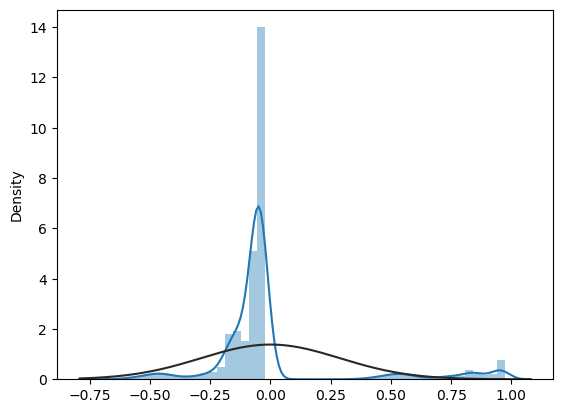

In [41]:
import warnings
warnings.filterwarnings('ignore')
sns.distplot(model.resid_generalized, fit=stats.norm) 

Распределение остатков сильно отличается от нормального распределения.

### Мультиколлинеарность

In [37]:
vifs = np.array([vif(model.model.exog, i) for i in range(model.model.exog.shape[1])])

In [39]:
vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model.params.index[1:]
vif_df.sort_values(by=['VIF'])

,VIF,Features
1,1.064684,cons.conf.idx
2,1.072564,nr.employed
12,1.096844,job_unemployed
8,1.117888,job_self-employed
4,1.128795,job_entrepreneur
10,1.135686,job_student
5,1.188688,job_housemaid
6,1.233386,job_management
9,1.420567,job_services
7,1.476707,job_retired


Нет значений VIF, превышающих 10. Проблема мультиколлинеарности отсутствует.

### Вывод

1.Модель объясняет примерно 16% вариаций зависимой переменной. Это может указывать на умеренную объясняющую способность. \
2.Практически все продеставленные коэффициенты имеют низкие p-значения, что указывает на статистическую значимость. Это положительно влияет, поскольку результаты становятся более надежными. \
3.Каждый коэфициент оценивает влияние соответствующего предиктора на вероятность оформления срочного депозита. Описание к каждому предоставлено выше. \
4.Лог-правдоподобие модели и тест отношения правдоподобия (LLR) свидетельствуют о статистической значимости модели в целом. \
\
Гипотезы:

1. Гипотеза H0 о влиянии возраста на то, оформит клиент банка срочный депозит или нет, подтвердилась. Возраст не оказывает статистически значимого влияния на то, оформит клиент срочный депозит или нет
2. Гипотеза Н1 о влиянии индекса потребительского доверия на то, оформит клиент банка срочный депозит или нет, подтвердилась. Индекс потребительского доверия оказывает статистически значимое влияния на то, оформит клиент срочный депозит или нет
3. Гипотеза Н1 о влиянии числа сотрудников на то, оформит клиент банка срочный депозит или нет, подтвердилась. Число сотрудников оказывает статистически значимое влияния на то, оформит клиент срочный депозит или нет
4. Гипотеза Н1 о влиянии типа работы на то, оформит клиент банка срочный депозит или нет, подтвердилась. Тип работы зачастую оказывает статистически значимое влияния на то, оформит клиент срочный депозит или нет
5. Гипотеза Н0 о влиянии семейного положения на то, оформит клиент банка срочный депозит или нет, подтвердилась. Семейное положение совсем не оказывает статистически значимое влияния на то, оформит клиент срочный депозит или нет
6. Гипотеза Н0 о влиянии образования на то, оформит клиент банка срочный депозит или нет, подтвердилась. Образование почти не оказывает статистически значимое влияния на то, оформит клиент срочный депозит или нет

# Этот файл нужно сохранить как Notebook (.ipynb) и загрузить в Smart LMS до 23:55 30 ноября.